# Sequential Parameter Optimization
## `river` Hyperparameter Tuning: HTR with User Data 

In [1]:
pip list | grep spot

pyspot                                    0.0.1
pyspotriver                               0.0.3
pyspotstream                              0.2.0
spotPython                                0.0.8
spotRiver                                 0.0.11
Note: you may need to restart the kernel to use updated packages.


In [2]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall http://www.gm.fh-koeln.de/~bartz/site/spotPython.tar.gz

## Example 1: HTR Hyperparameter

In [3]:
import numpy as np
from math import inf
from spotRiver.fun.hyperriver import HyperRiver
from spotPython.spot import spot
from spotRiver import data
from scipy.optimize import shgo
from scipy.optimize import direct
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt
from spotRiver.utils.selectors import select_leaf_prediction
from spotRiver.utils.selectors import select_leaf_model

### 1 The Objective Function 

* Here we will use the river `HATR` function.
* First, the function will be tested independently from `Spot`.

In [4]:
import numpy as np
import datetime as dt
from river import datasets
from river import time_series
from river import utils
import calendar
import math
from river import compose
from river import linear_model
from river import optim
from river import preprocessing
from river import metrics
from spotRiver.fun.hyperriver import HyperRiver

fun = HyperRiver(123).fun_HTR_iter_progressive
var_type = ["int"] * 2 + ["num"] * 2 + ["factor"] * 2 + ["float"] + ["int"] * 2 + ["factor"] + ["float"]
var_type



['int',
 'int',
 'num',
 'num',
 'factor',
 'factor',
 'float',
 'int',
 'int',
 'factor',
 'float']

* Note: Instead of using the Airline Passenger data as in notebook 01, we demonstrate the usage of user specified data which is *not* part of the `spotRiver` package!

## User Specified Data

In [5]:
# from pyspotstream.datasets import fetch_opm
# ds = fetch_opm(include_categorical=False, data_home="data", return_X_y=True)

* Important: Specify the location of your data, e.g., `/home/data/` etc.

In [6]:
from spotRiver.data.generic import GenericData
fraction = 1.0
dataset = GenericData(filename="opm_num.zip",
                      directory=".",
                      target="Sale Amount",
                      n_features=7,
                      n_samples=985_862,
                      fraction = fraction,
                      converters={'List Year': int,
                                  'Assessed Value': float,
                                  'Sale Amount': float,
                                  'Sales Ratio': float,
                                  'lon': float,
                                  'lat': float,
                                  'timestamp_rec': float},
                      parse_dates=None
                      # parse_dates={"Date Recorded": "%Y-%m-%d"}
                      )
n_samples = int(dataset.n_samples * fraction)

# CHECK Data Set

In [7]:
# from river.datasets import synth
# dataset = synth.Friedman(seed=42).take(100_000)
# n_samples = 500_000

In [8]:
for x,y in dataset:
    print(x,y)
    break

{'List Year': 2001, 'Assessed Value': 107530.0, 'Sales Ratio': 0.575026738, 'lat': 41.50021401170393, 'lon': -72.87396263711757, 'timestamp_rec': 1001894400.0} 187000.0


In [9]:
# [[2.00e+02 1.00e+01 1.00e-06 7.50e-02 2.00e+00 1.00e+00 0.00e+00 7.00e+00 0.00e+00 3.12e+02]]
lower = np.array([100, 1,  1e-8, 0.025, 0, 0, 0.8,  0,  5, 0, 250.0])
upper = np.array([200, 10, 1e-6, 0.075, 1, 1, 0.975, 1, 10, 1, 750.0])
fun_control = {"data": dataset,
               "n_samples": n_samples,
               "weights": np.array([1/50_000, 1, 1])*1000}

### 3 Run the `Spot` Optimizer

* Since the data is larger than the airline passengers data, the max. time is increased.

In [10]:
spot_htr = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = 300,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type=var_type,
                   infill_criterion = "ei",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": 20,
                                   "repeats": 1},
                   surrogate_control={"noise": False,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": 11,
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 1000,
                                      })
spot_htr.run()

spotPython tuning: [##########] 100.00% Done...


### 4 Results 

* Print the Results

In [11]:
spot_htr.print_results()

min y: 0.03654392277453068
min X: [[1.00e+02 1.00e+00 1.00e-06 7.50e-02 0.00e+00 1.00e+00 1.00e+00 1.00e+00
  5.00e+00 1.00e+00 3.11e+02]]


* Show the Progress

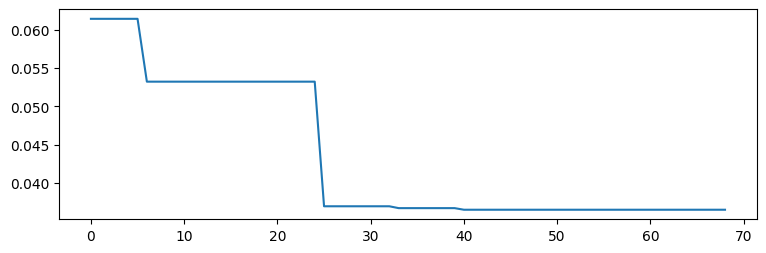

In [12]:
spot_htr.plot_progress(log_y=False)

In [13]:
spot_htr.print_importance()

Importance relative to the most important parameter:
Parameter 0 :  0.00011561197245188203
Parameter 1 :  0.33555828377509994
Parameter 2 :  1.000000000405204e-05
Parameter 3 :  0.0005945957940527194
Parameter 4 :  0.011019812895444339
Parameter 5 :  100.0
Parameter 6 :  0.00022158392691926565
Parameter 7 :  11.422436523505587
Parameter 8 :  0.00032843968945006126
Parameter 9 :  1.0000000130245658e-05
Parameter 10 :  0.004698667761276412


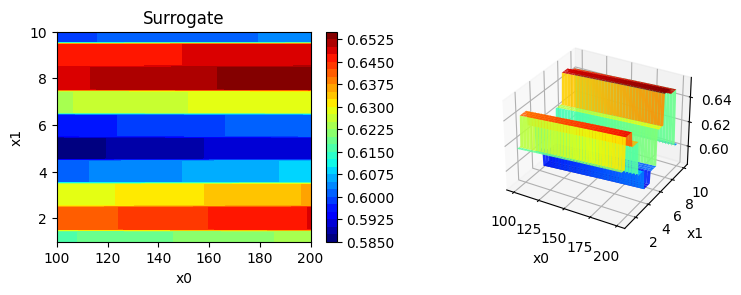

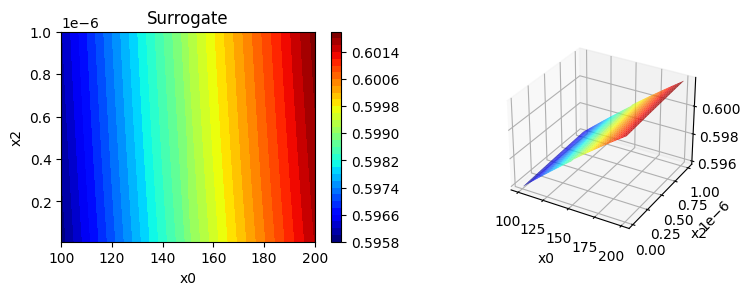

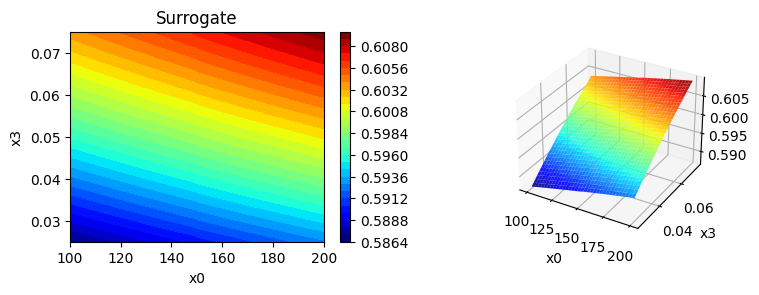

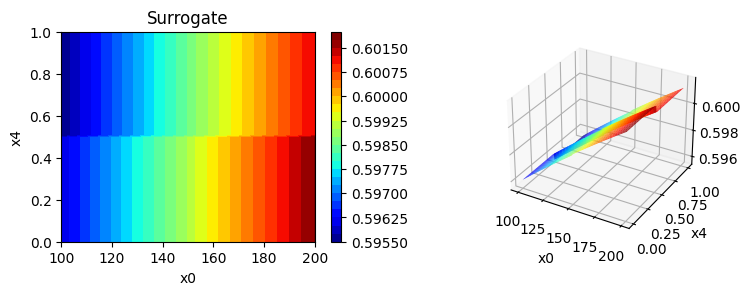

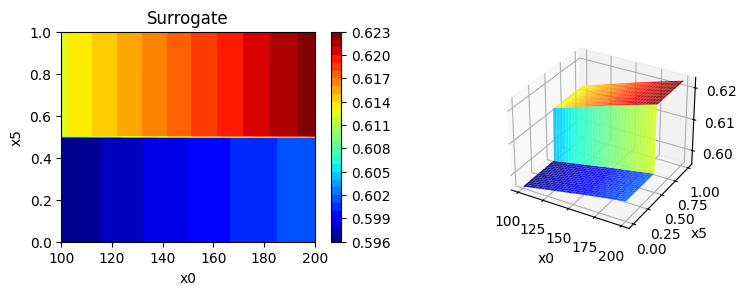

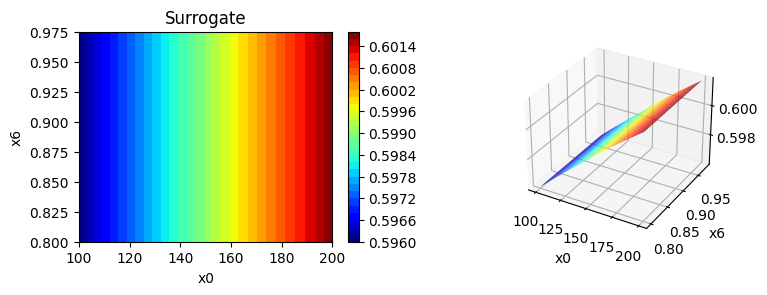

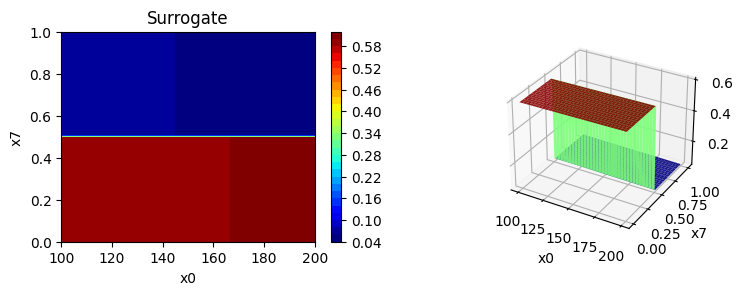

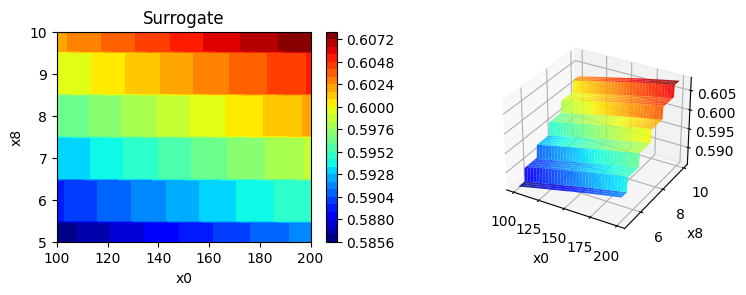

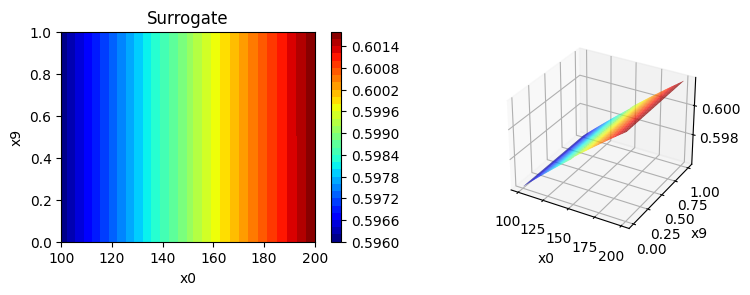

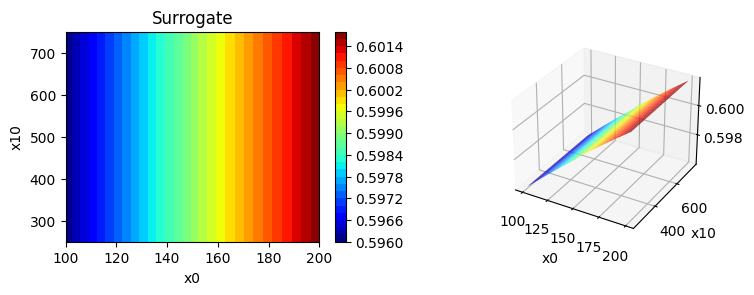

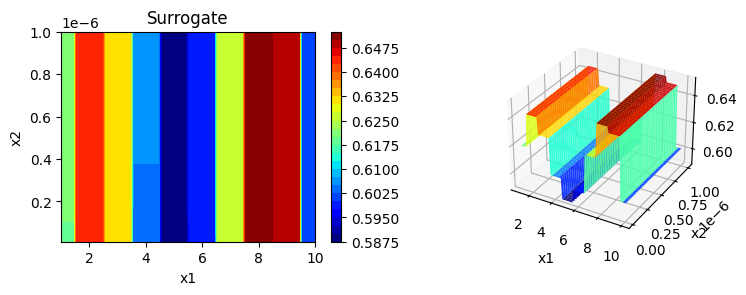

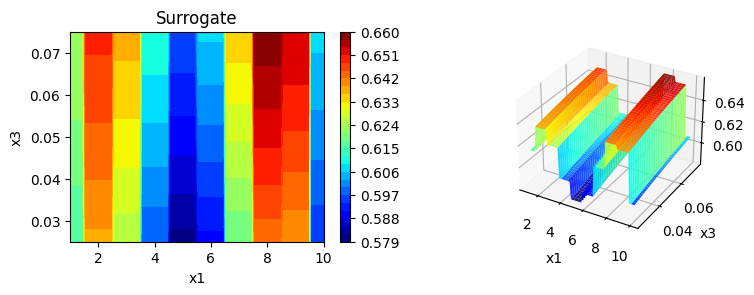

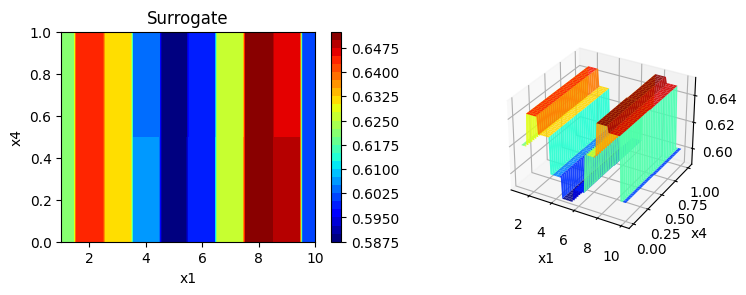

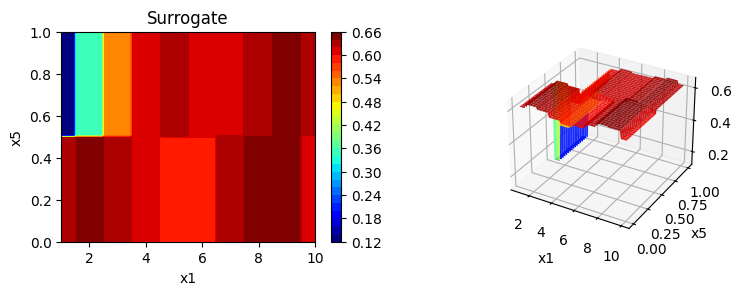

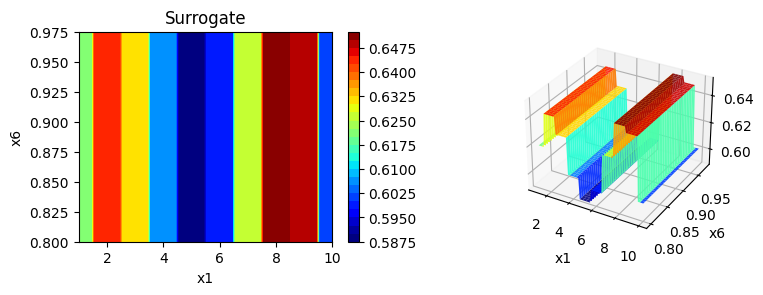

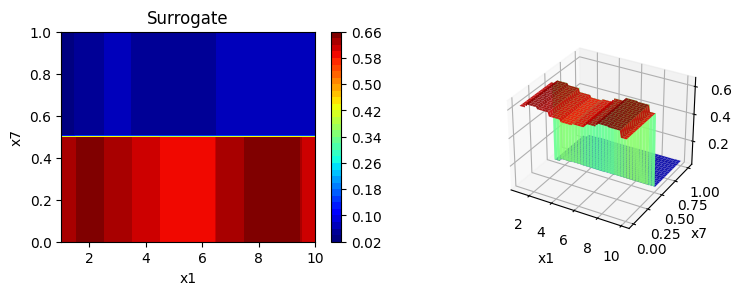

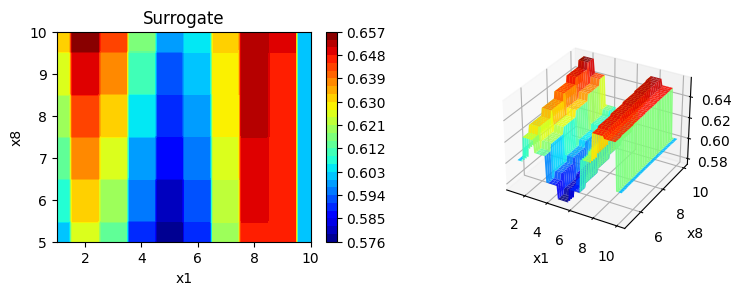

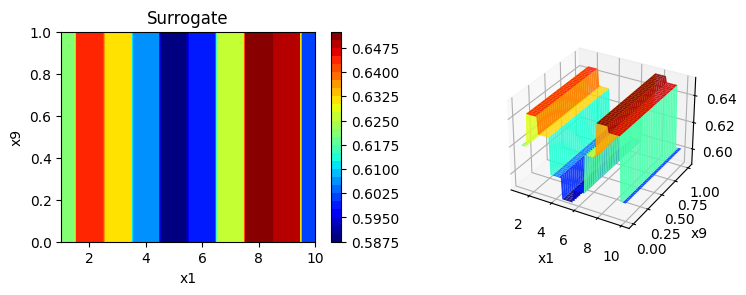

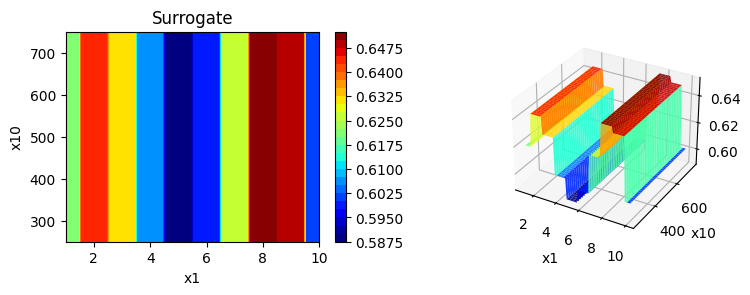

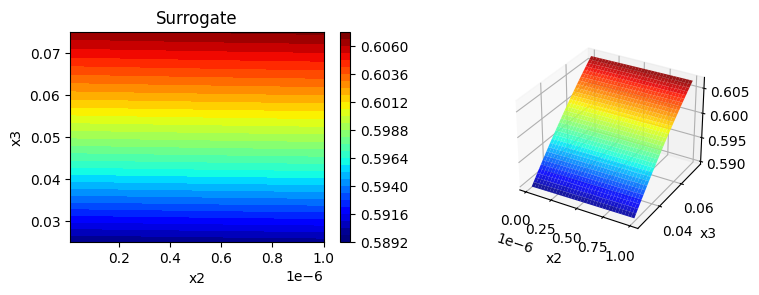

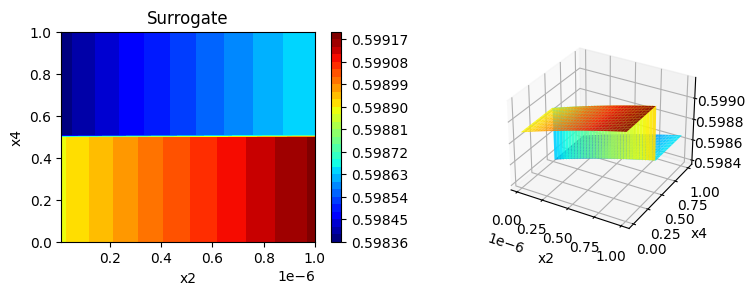

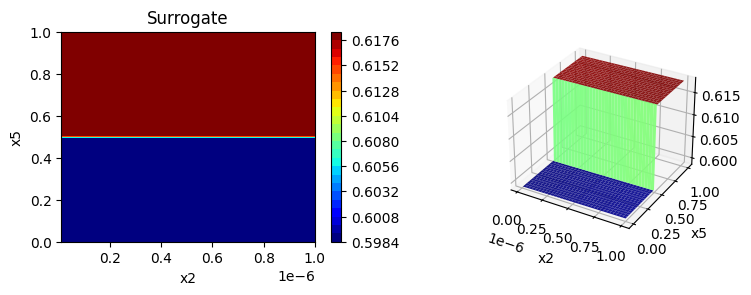

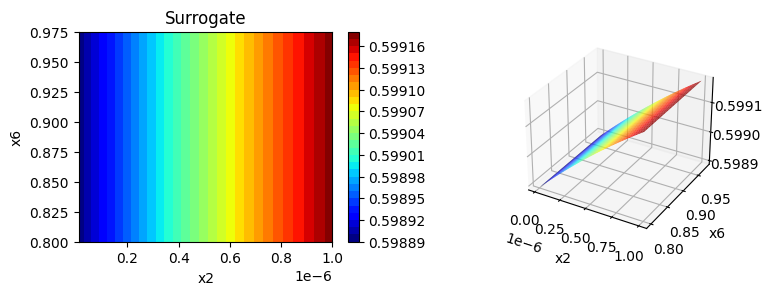

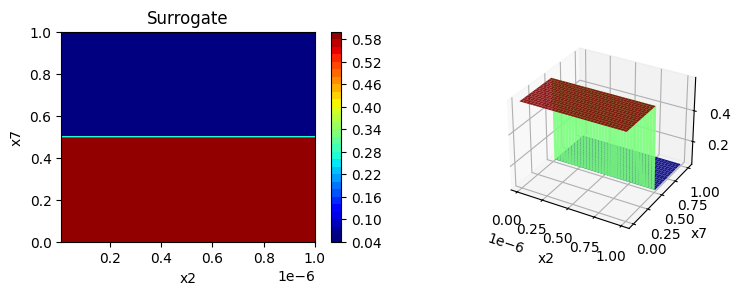

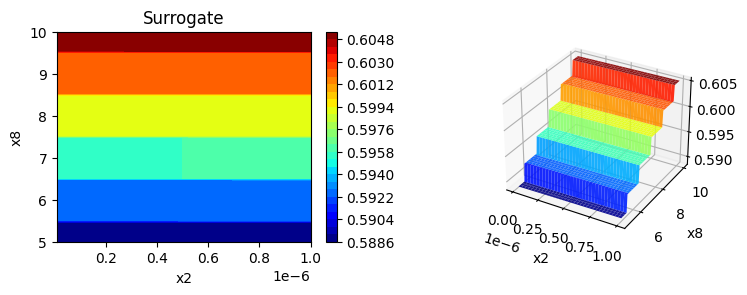

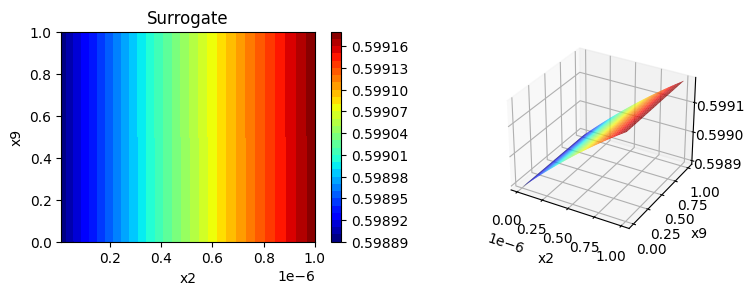

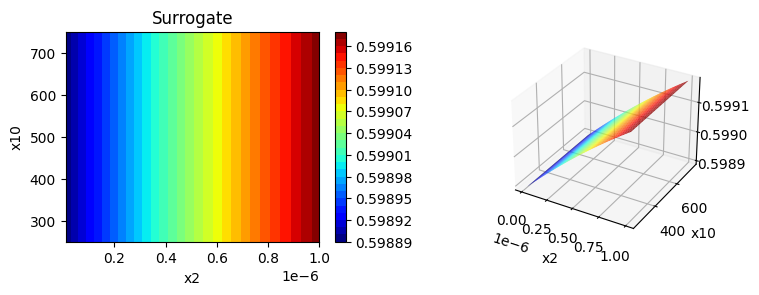

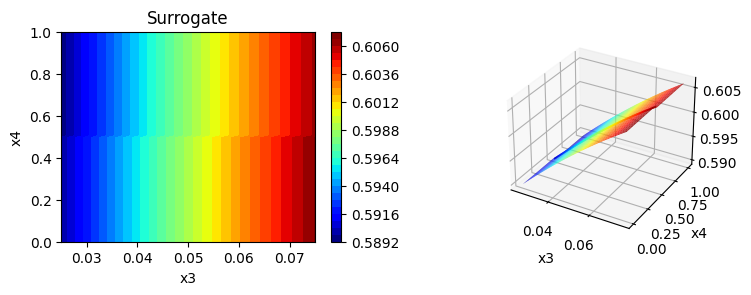

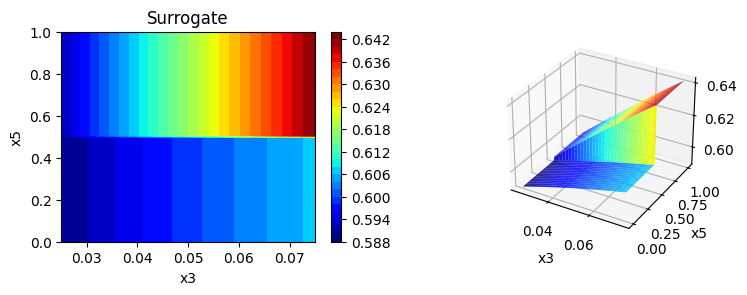

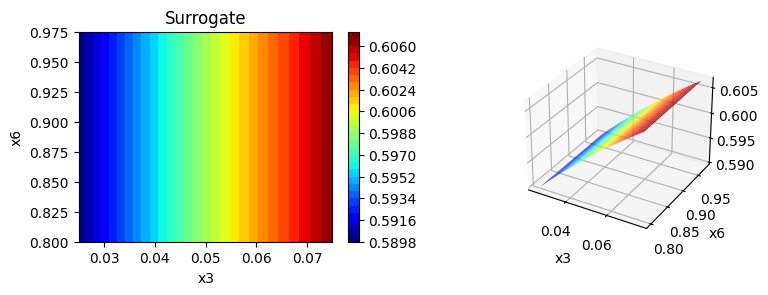

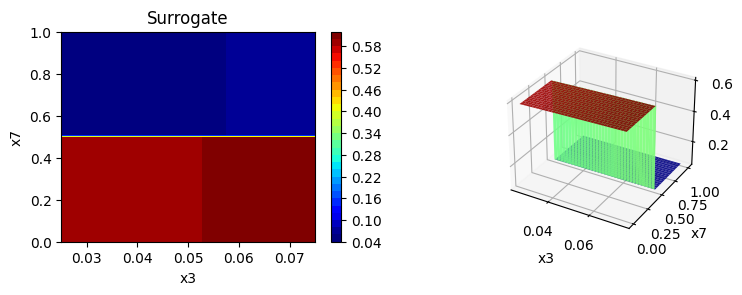

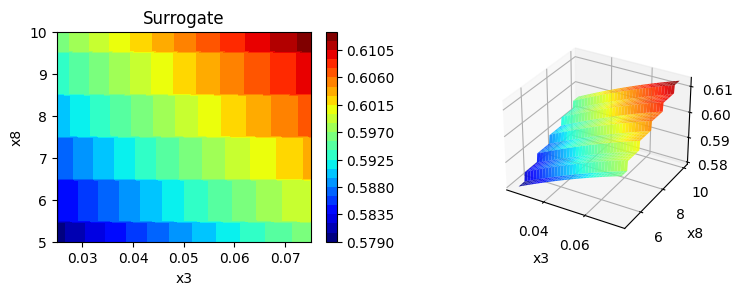

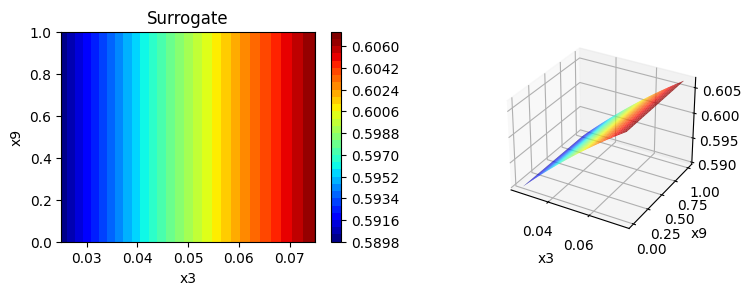

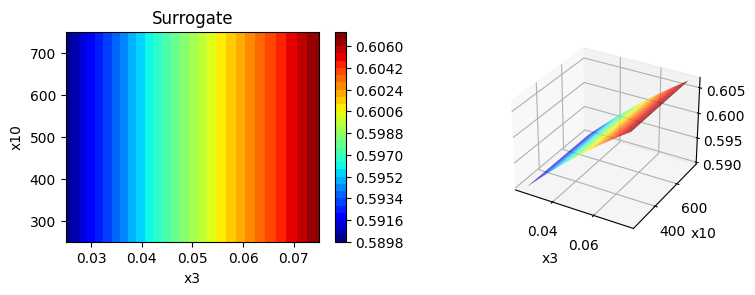

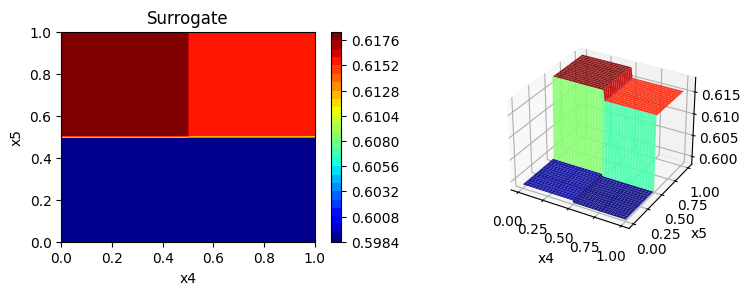

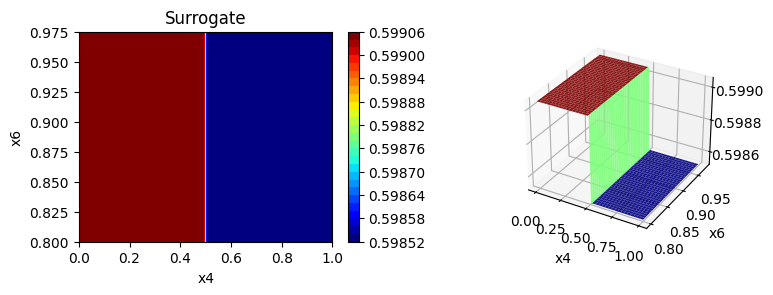

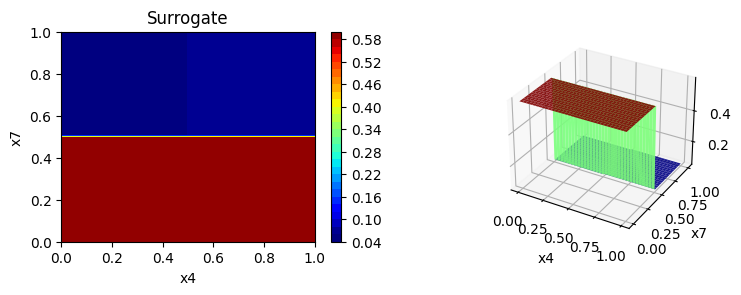

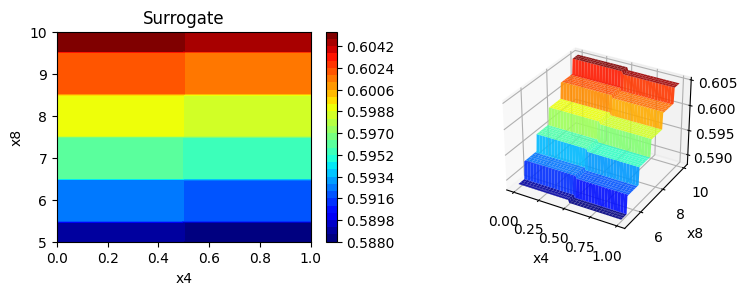

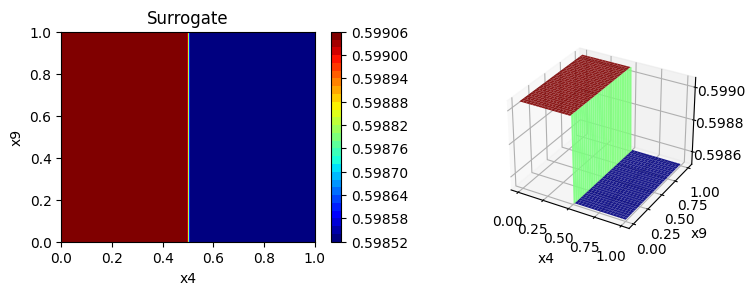

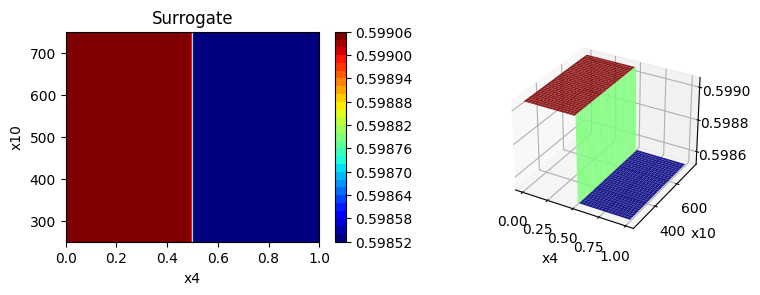

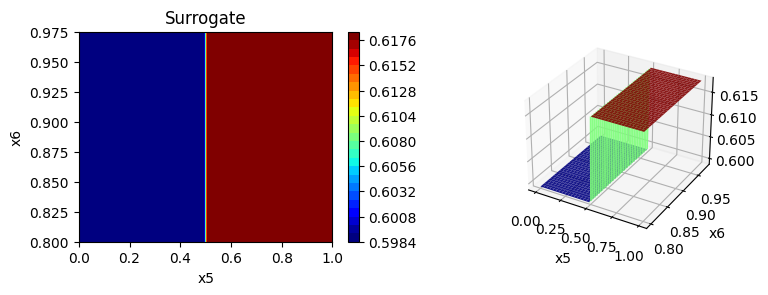

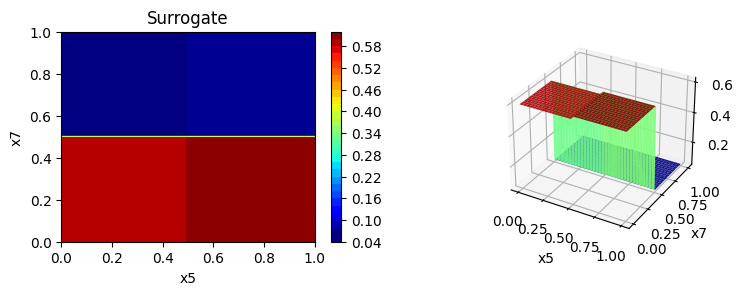

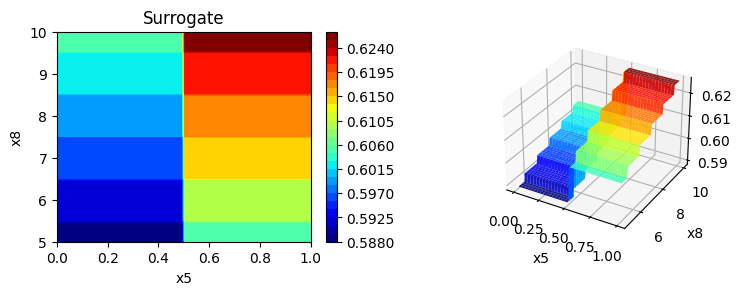

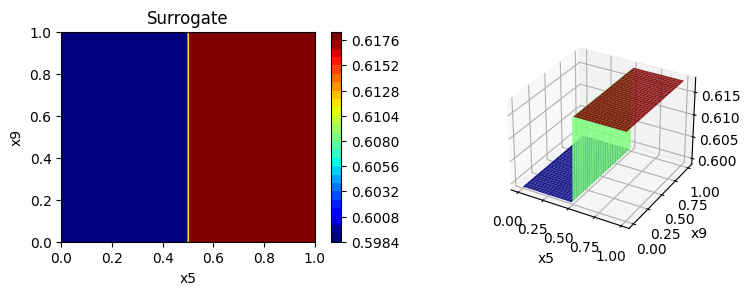

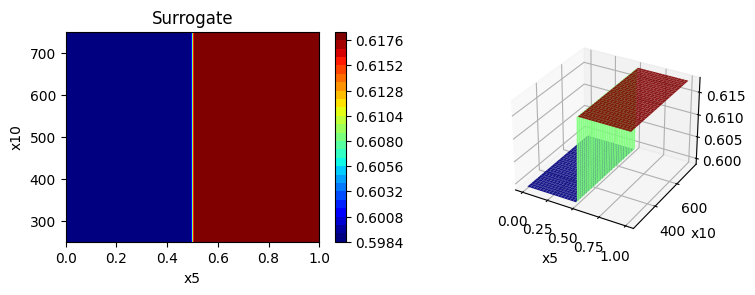

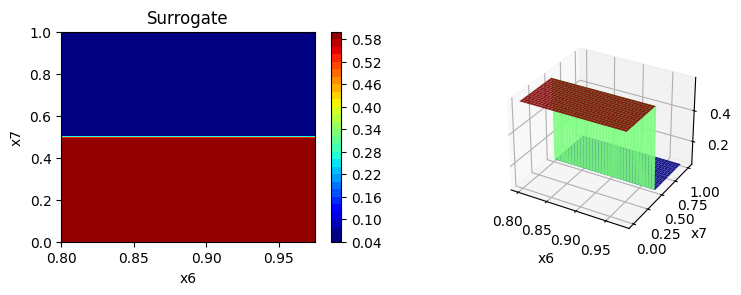

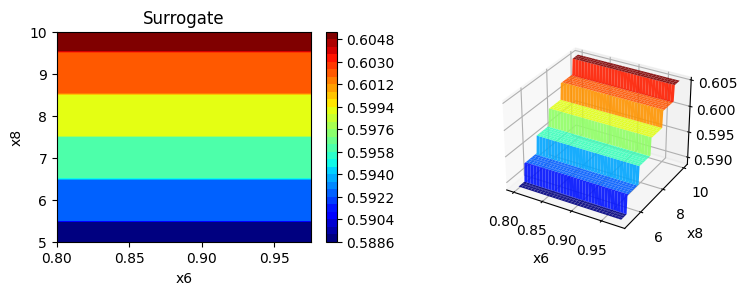

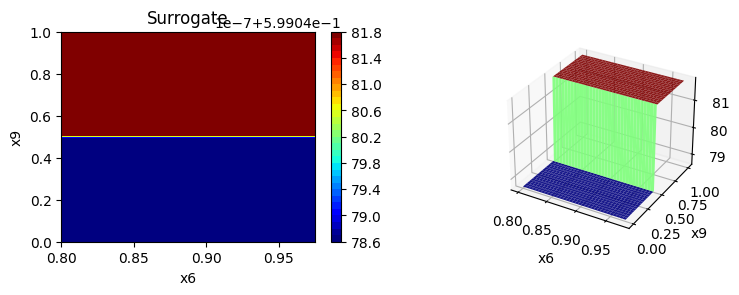

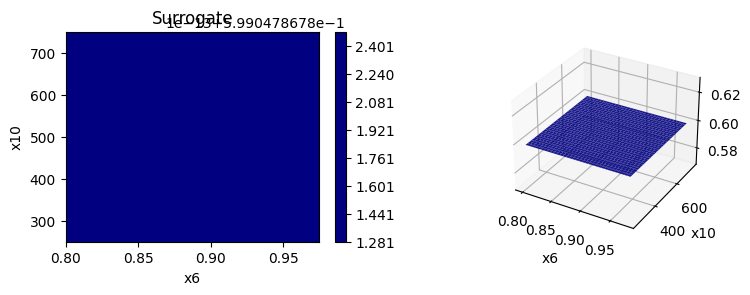

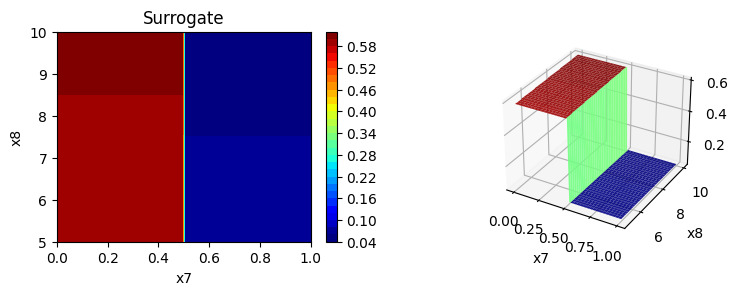

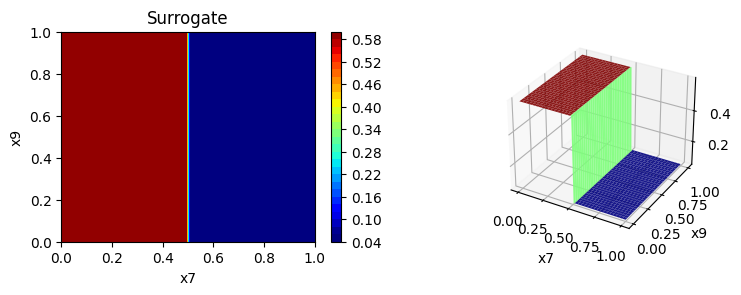

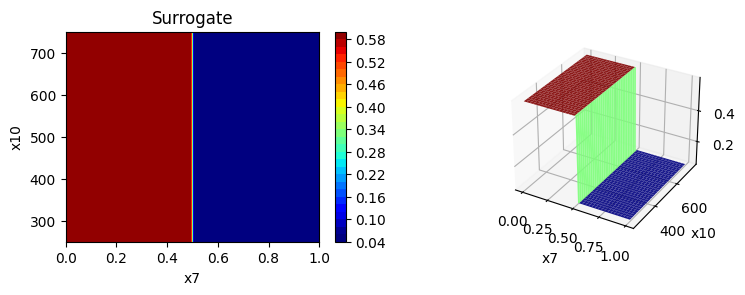

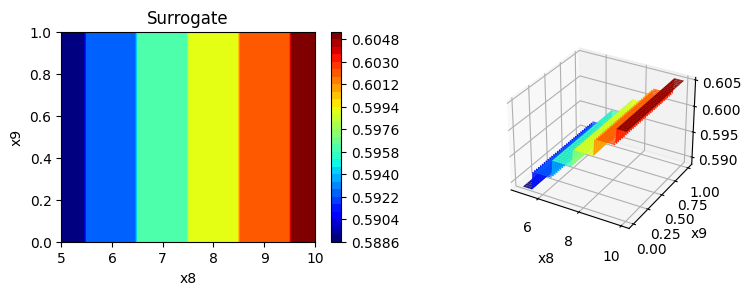

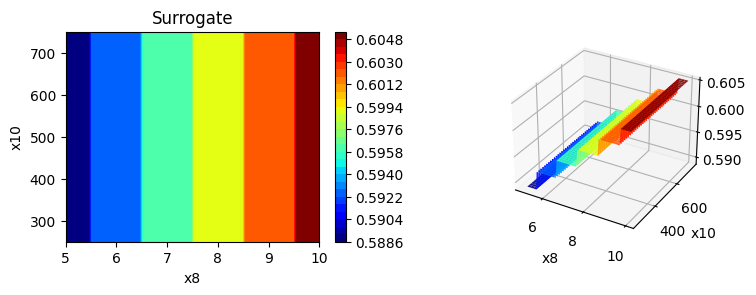

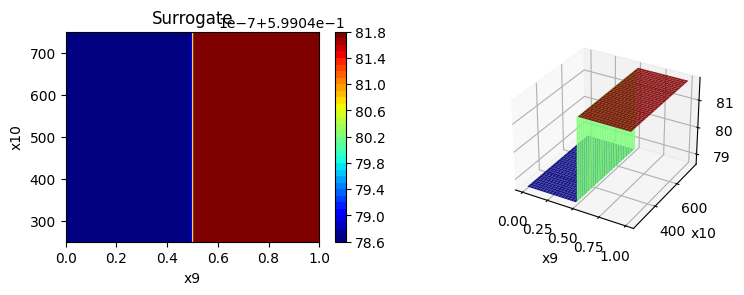

In [14]:
n = spot_htr.k
for i in range(n-1):
    for j in range(i+1, n):
        spot_htr.plot_contour(i=i, j=j)

## Build and Evaluate HTR Model with Tuned Hyperparameters

In [15]:
X = spot_htr.to_all_dim(spot_htr.min_X.reshape(1,-1))
print(X)
grace_period = X[:, 0]
max_depth = X[:, 1]
delta = X[:, 2]
tau = X[:, 3]
leaf_prediction = X[:, 4]
leaf_model = X[:, 5]
model_selector_decay = X[:, 6]
splitter = X[:, 7]
min_samples_split = X[:, 8]
binary_split = X[:, 9]
max_size = X[:, 10]


[[1.00e+02 1.00e+00 1.00e-06 7.50e-02 0.00e+00 1.00e+00 1.00e+00 1.00e+00
  5.00e+00 1.00e+00 3.11e+02]]


In [16]:
import numbers
from river import tree
from spotRiver.evaluation.eval_oml import fun_eval_oml_iter_progressive
from spotRiver.evaluation.eval_oml import eval_oml_iter_progressive
from spotRiver.utils.selectors import select_splitter
from spotRiver.utils.selectors import select_max_depth
num = compose.SelectType(numbers.Number) | preprocessing.StandardScaler()
cat = compose.SelectType(str) | preprocessing.FeatureHasher(n_features=1000, seed=1)
res = eval_oml_iter_progressive(
    dataset=fun_control["data"],
    step=10000,
    verbose=True,
    metric=metrics.MAE(),
    models={
         "Default: HTR + QO": (
             (num + cat) | tree.HoeffdingTreeRegressor(
                splitter=tree.splitter.QOSplitter()
            )
        ),
        "SPOT: HTR + QO": (
            (num + cat) | tree.HoeffdingTreeRegressor(
                grace_period=int(grace_period),
                max_depth=select_max_depth(int(max_depth)),
                delta=float(delta),
                tau=float(tau),
                leaf_prediction=select_leaf_prediction(int(leaf_prediction)),
                leaf_model=select_leaf_model(int(leaf_model)),
                splitter=select_splitter(int(splitter)),
                min_samples_split=int(min_samples_split),
                binary_split=int(binary_split),
                max_size=float(max_size)
            )
        ),
    }
)
y = fun_eval_oml_iter_progressive(res, metric=None)

Eval iter_prog_val_score: [##########] 100.00% Done...
Eval iter_prog_val_score: [##########] 100.00% Done...


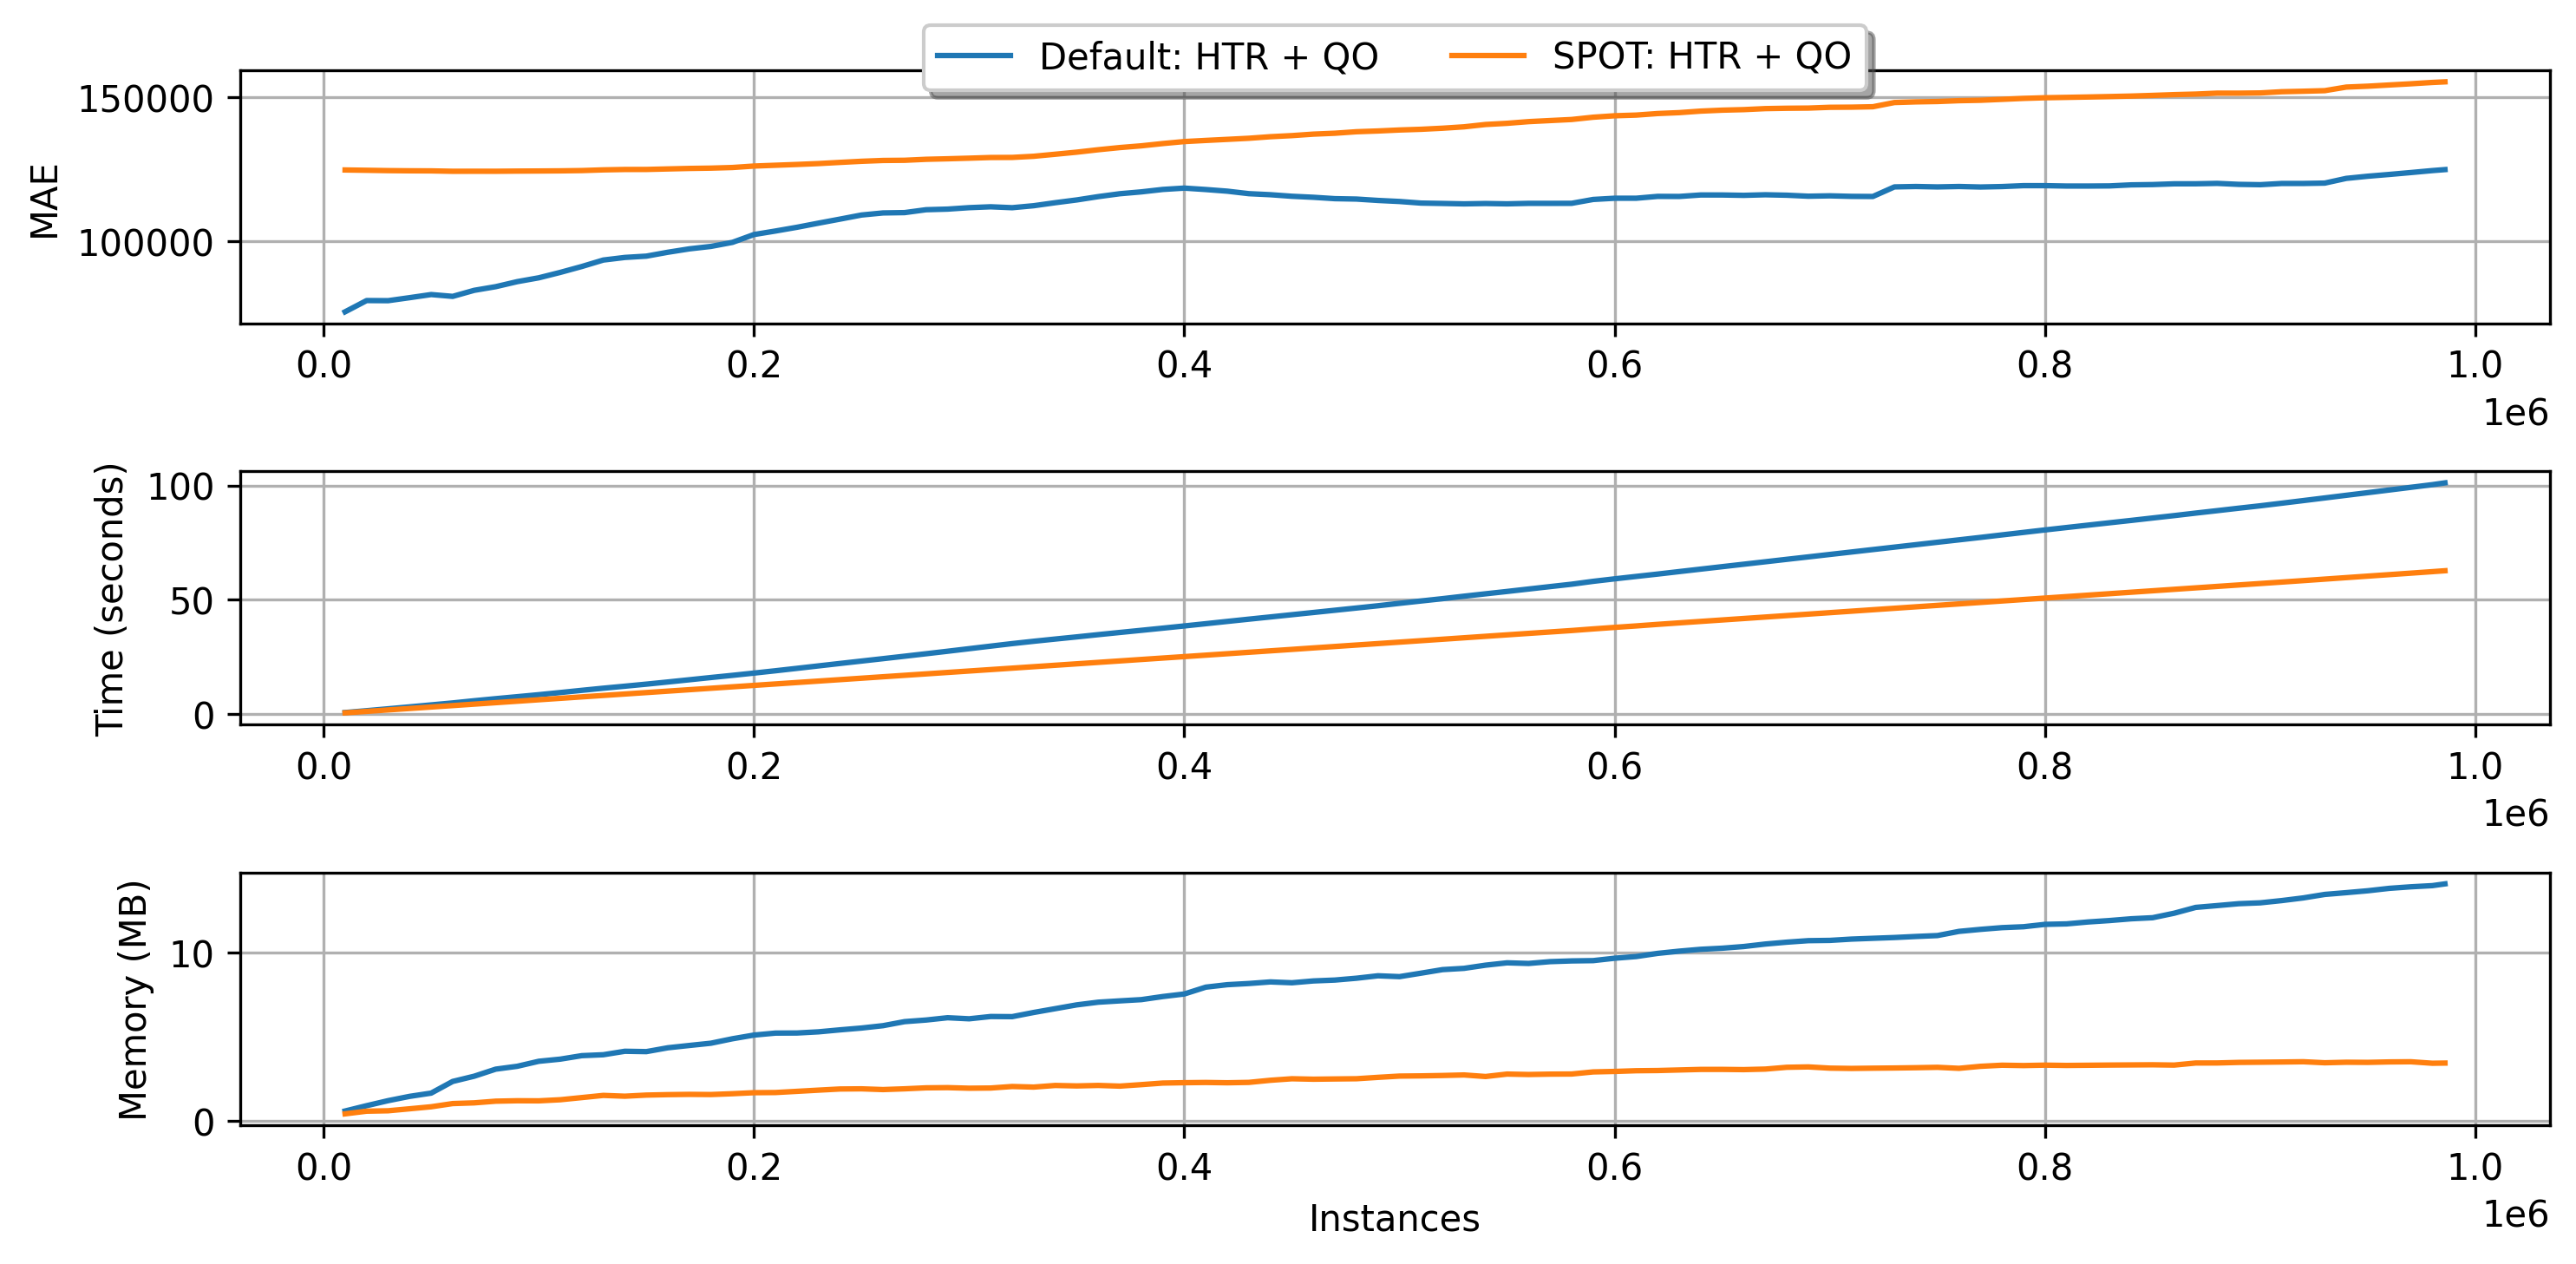

In [17]:
from spotRiver.evaluation.eval_oml import plot_oml_iter_progressive
plot_oml_iter_progressive(res, log_y=False)

In [18]:
# model
# model["ts"].regressor["lm"].weights
# forecast = model.forecast(horizon=fun_control["horizon"])
# forecast
